In [1]:
%matplotlib inline
import matplotlib
import os
import pandas as pd
import louvain
import igraph as ig

import collections
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from nwtools import communities, common

In [2]:
edges_dict = {}
datapath = '/media/sf_VBox_Shared/networks/trade/import/'
for year in range(1995, 2013):
    edges_dict[str(year)] = pd.read_csv(os.path.join(datapath, 'import-links-{}.csv'.format(year))
                                       , keep_default_na=False)

In [3]:
nodes = pd.read_csv('/media/sf_VBox_Shared/networks/trade/countries.csv', keep_default_na=False,  
                    index_col='Id')

In [4]:
for year in edges_dict:
    edges_dict[year]['Distance'] = 1.0 / edges_dict[year]['Weight']

In [5]:
def igraph_from_edgelist(edges, source='Source', target='Target', attributes=None):
    g = ig.Graph()

    node_names = list(set(edges[source]).union(set(edges[target])))

    g.add_vertices(node_names)

    g.add_edges([(s, t) for s, t in edges[[source, target]].values])
    
    if attributes is None:
        attributes = ['Weight']
    for att in attributes:
        g.es[att.lower()] = list(edges[att])
        
    return g

In [6]:
graphs = {year: common.igraph_from_pandas_edgelist(edges_dict[year], attributes=['Weight', 'Distance'], directed=True)
          for year in edges_dict}

In [7]:
import leidenalg as la

def consensus_partition(g, 
                        partition_type = la.ModularityVertexPartition,
                        weights=None,
                        nr_partitions = 100,
                        threshold = 0,
                        max_nr_iterations = 5,
                       verbose=False, **kwargs):
    '''
    Partitions graph based on consensus clustering
    :param g: igraph Graph
    '''
    n = len(g.vs)
    graph = g
    for j in range(max_nr_iterations):
        if verbose:
            print('Iteration {}'.format(j))

        consensus_matrix = np.zeros((n, n))
        for i in range(nr_partitions):
            partition = la.find_partition(graph, partition_type=partition_type, weights=weights, **kwargs)
            k = len(partition.sizes()) # Number of partitions
            b = np.zeros((n, k))
            b[np.arange(n), partition.membership] = 1
            consensus_matrix += b.dot(b.T)
        consensus_matrix /= nr_partitions

        g2 = graph.copy()
        g2.delete_edges(g2.es)

        consensus_matrix_fixed = consensus_matrix.copy()
        consensus_matrix_fixed[consensus_matrix<=threshold] = 0
        ix, jx = consensus_matrix_fixed.nonzero()
        for i,j in zip(list(ix), list(jx)):
            if i!=j: # is this necessary?
                g2.add_edge(i,j,weight=consensus_matrix_fixed[i,j])
        # are there any solo clusters?
        ccs = g2.clusters()
        if verbose:
            print('Smallest connected component: {}'.format(min(ccs.sizes())))

        # plot adjacency matrix
        if verbose:
            communities.plot_sorted_adjacency(consensus_matrix, partition.membership)
        
        # Check if converged
        if(min(consensus_matrix[consensus_matrix.nonzero()])==1):
            if verbose:
                print('Converged!')
            return consensus_matrix, ccs.membership
        graph = g2
        weights = 'weight'
        
    return consensus_matrix, ccs.membership

Iteration 0
Smallest connected component: 9


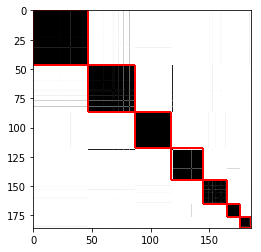

Iteration 1
Smallest connected component: 9


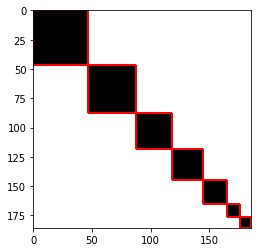

Converged!
Iteration 0
Smallest connected component: 1


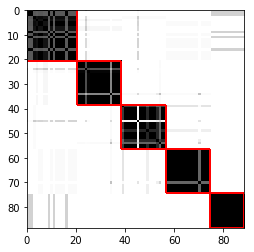

Iteration 1
Smallest connected component: 1


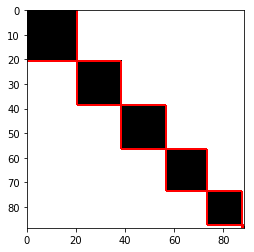

Converged!
Iteration 0
Smallest connected component: 1


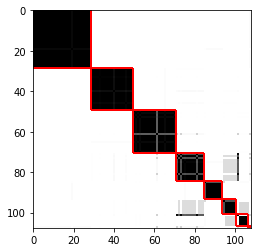

Iteration 1
Smallest connected component: 1


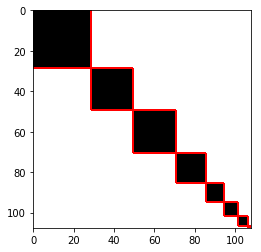

Converged!
Iteration 0
Smallest connected component: 4


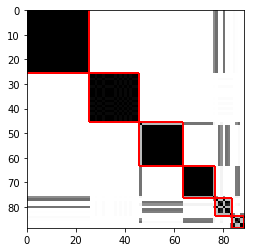

Iteration 1
Smallest connected component: 4


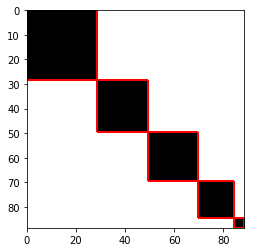

Converged!
Iteration 0
Smallest connected component: 1


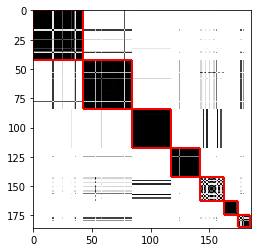

Iteration 1
Smallest connected component: 1


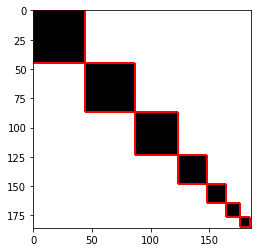

Converged!
Iteration 0
Smallest connected component: 10


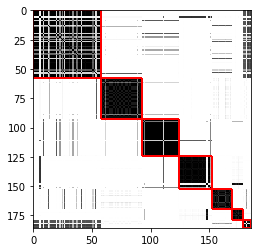

Iteration 1
Smallest connected component: 10


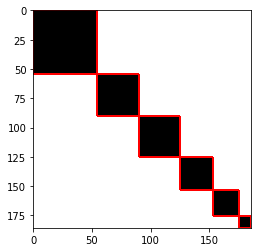

Converged!
Iteration 0
Smallest connected component: 1


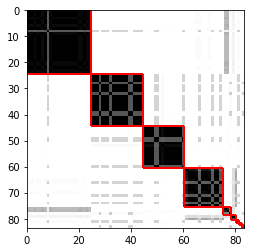

Iteration 1
Smallest connected component: 1


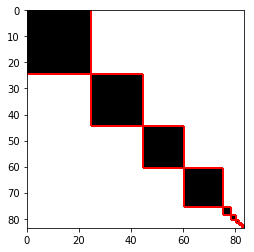

Converged!
Iteration 0
Smallest connected component: 1


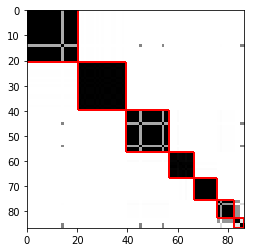

Iteration 1
Smallest connected component: 1


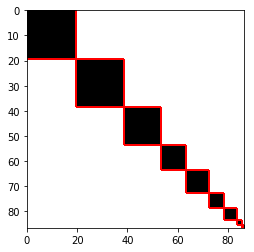

Converged!
Iteration 0
Smallest connected component: 9


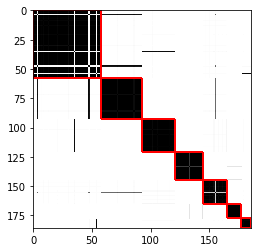

Iteration 1
Smallest connected component: 9


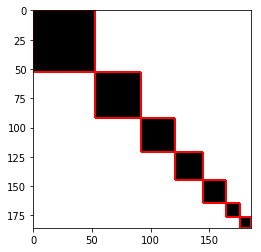

Converged!
Iteration 0
Smallest connected component: 1


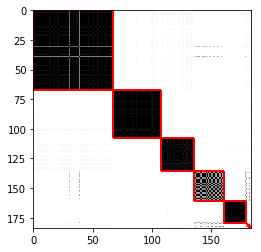

Iteration 1
Smallest connected component: 1


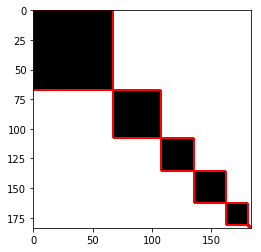

Converged!
Iteration 0
Smallest connected component: 1


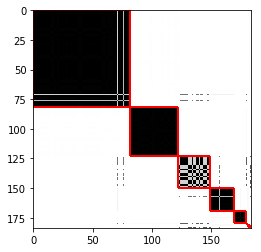

Iteration 1
Smallest connected component: 1


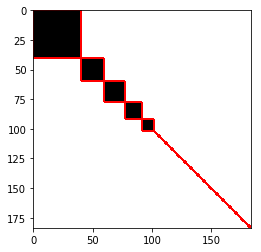

Converged!
Iteration 0
Smallest connected component: 1


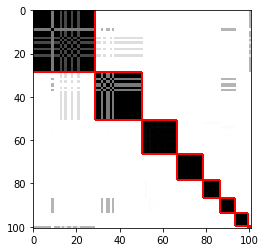

Iteration 1
Smallest connected component: 1


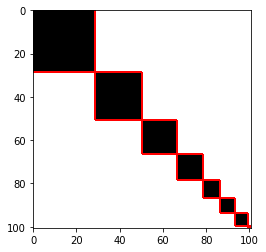

Converged!
Iteration 0
Smallest connected component: 1


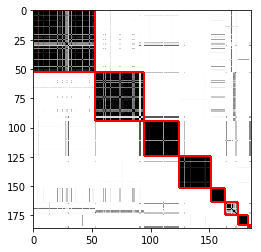

Iteration 1
Smallest connected component: 1


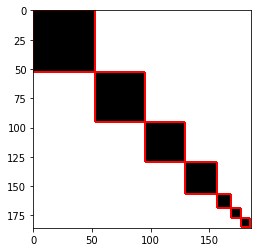

Converged!
Iteration 0
Smallest connected component: 1


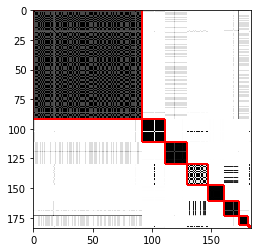

Iteration 1
Smallest connected component: 1


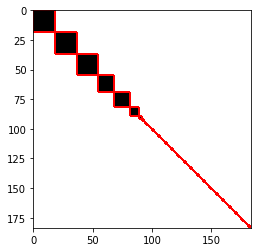

Converged!
Iteration 0
Smallest connected component: 1


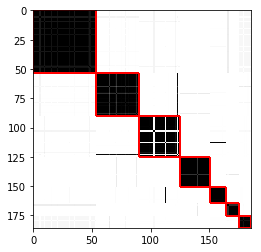

Iteration 1
Smallest connected component: 1


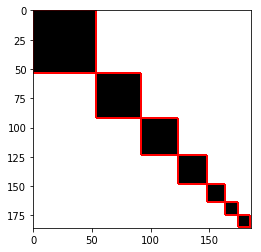

Converged!
Iteration 0
Smallest connected component: 10


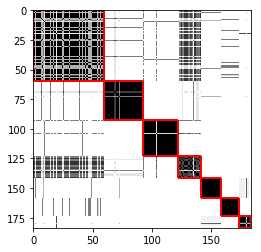

Iteration 1
Smallest connected component: 10


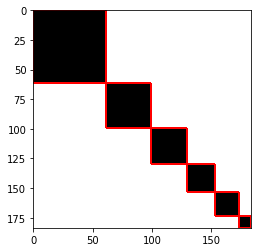

Converged!
Iteration 0
Smallest connected component: 1


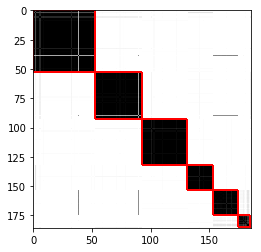

Iteration 1
Smallest connected component: 1


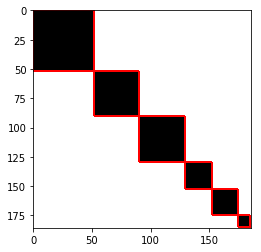

Converged!
Iteration 0
Smallest connected component: 14


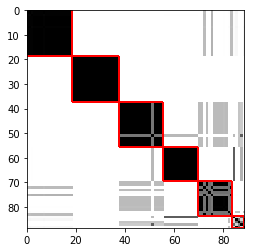

Iteration 1
Smallest connected component: 4


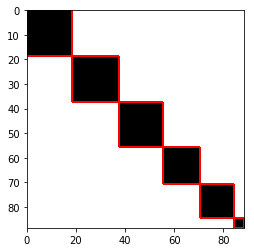

Iteration 2
Smallest connected component: 4


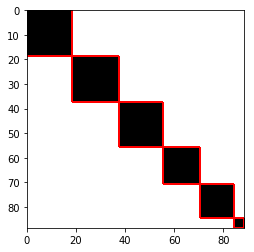

Converged!


In [8]:
consensus_matrices_dict = {}
partition_dict = {}
for year in graphs:
    cons, part = consensus_partition(graphs[year], verbose=True, threshold=0.5, 
                                     nr_partitions=100, weights='Weight',
                                    partition_type=la.RBConfigurationVertexPartition, resolution_parameter=1.5)
    consensus_matrices_dict[year] = cons
    partition_dict[year] = part

In [9]:
# Filter out single communities 
partition_filtered_dict = {}
from collections import Counter
for year in graphs:
    part_sizes = Counter(partition_dict[year])
    partition_filtered_dict[year] = [p if part_sizes[p] > 1 else np.nan for p in partition_dict[year]]

In [10]:
nodes_merged = nodes.copy()

for year in partition_dict:
    consensus_s = pd.Series(partition_filtered_dict[year], index=graphs[year].vs['name'])
    nodes_merged['consensus_{}'.format(year)] = consensus_s
    
nodes_merged = nodes_merged.dropna(subset=['consensus_{}'.format(y) for y in graphs], how='all')

In [11]:
consensus_columns = ['consensus_{}'.format(year) for year in graphs]

In [12]:
def add_statistics(graph, nodes, suffix):
    names = graph.vs.get_attribute_values('name')
    
    nodes['degree_'+suffix] = pd.Series(graph.degree(), index=names)
    nodes['weighted_degree_'+suffix] = pd.Series(graph.strength(weights='Weight'), index=names)
    nodes['eigenvector_centrality_'+suffix] = pd.Series(
        graph.eigenvector_centrality(directed=False, weights='Weight'), index=names)
    nodes['betweenness_'+suffix] = pd.Series(graph.betweenness(directed=False, weights='Distance'), index=names)

In [13]:
for year in graphs.keys():
    add_statistics(graphs[year], nodes_merged, year)

In [14]:
nodes_merged.head()

,Label,latitude,longitude,name,consensus_2011,consensus_1996,consensus_2000,consensus_2012,consensus_2007,consensus_2002,...,eigenvector_centrality_2005,betweenness_2005,degree_2006,weighted_degree_2006,eigenvector_centrality_2006,betweenness_2006,degree_1997,weighted_degree_1997,eigenvector_centrality_1997,betweenness_1997
Id,,,,,,,,,,,,,,,,,,,,,
AE,United Arab Emirates,23.424076,53.847818,United Arab Emirates,4.0,5.0,7.0,4.0,1.0,93.0,...,0.009368,0.0,33.0,7430.5578,0.012010,0.0,2.0,374.8647,0.002310,0.0
AF,Afghanistan,33.93911,67.709953,Afghanistan,1.0,NaN,NaN,7.0,3.0,93.0,...,0.000128,0.0,24.0,123.2659,0.000149,0.0,NaN,NaN,NaN,NaN
AG,Antigua and Barbuda,17.060816,-61.796428,Antigua and Barbuda,3.0,NaN,NaN,7.0,5.0,NaN,...,0.000576,0.0,22.0,273.1213,0.000658,0.0,NaN,NaN,NaN,NaN
AI,Anguilla,18.220554,-63.068615,Anguilla,6.0,NaN,6.0,6.0,5.0,NaN,...,0.000017,0.0,16.0,16.7384,0.000020,0.0,NaN,NaN,NaN,NaN
AL,Albania,41.153332,20.168331,Albania,5.0,3.0,5.0,5.0,2.0,94.0,...,0.000389,0.0,23.0,289.7031,0.000381,0.0,3.0,2.2242,0.000002,0.0


In [15]:
nodes_merged.sort_values('weighted_degree_2008', ascending=False).head()

,Label,latitude,longitude,name,consensus_2011,consensus_1996,consensus_2000,consensus_2012,consensus_2007,consensus_2002,...,eigenvector_centrality_2005,betweenness_2005,degree_2006,weighted_degree_2006,eigenvector_centrality_2006,betweenness_2006,degree_1997,weighted_degree_1997,eigenvector_centrality_1997,betweenness_1997
Id,,,,,,,,,,,,,,,,,,,,,
US,United States,37.09024,-95.712891,United States,0.0,2.0,4.0,2.0,0.0,79.0,...,1.000000,7511.0,72.0,588353.4635,1.000000,8492.0,28.0,246824.0833,1.000000,3118.0
GB,United Kingdom,55.378051,-3.435973,United Kingdom,1.0,1.0,5.0,7.0,5.0,90.0,...,0.783750,8011.0,218.0,401135.3683,0.789742,8384.0,53.0,81276.4690,0.530324,892.0
DE,Germany,51.165691,10.451526,Germany,5.0,3.0,3.0,5.0,2.0,94.0,...,0.610576,3884.0,63.0,323982.0451,0.600250,2672.0,25.0,65044.5295,0.349724,1346.0
FR,France,46.227638,2.213749,France,6.0,4.0,1.0,6.0,4.0,NaN,...,0.443473,5561.0,218.0,223568.5140,0.431547,6265.0,23.0,37677.4793,0.256452,645.0
JP,Japan,36.204824,138.252924,Japan,4.0,5.0,7.0,4.0,1.0,79.0,...,0.503486,722.0,68.0,186469.7097,0.478931,727.0,49.0,122672.9628,0.659761,1127.0


In [16]:
from scipy.optimize import linear_sum_assignment

In [17]:
def get_mapping(ctab):
    if ctab.shape[0] > ctab.shape[1]:
        raise Exception('Rows should be fewer than columns')
        
    # Use the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(- ctab.values)
    mapXtoY = {ctab.index[r]: ctab.columns[c] for r, c in zip(row_ind, col_ind)}
    return(mapXtoY)

In [191]:
import itertools

def jaccard(s1, s2):
    intersect = len(s1.intersection(s2))
    union = len(s1.union(s2))
    if union==0:
        return np.NaN
    return intersect/union

def jaccard_dataframe(s1, s2):
    lab1 = s1.dropna()
    lab2 = s2.dropna()
    
    cols1 = sorted(lab1.unique())
    cols2 = sorted(lab2.unique())
    
    sim_df = pd.DataFrame(index=cols1, columns=cols2)
    sim_df.index.name = lab1.name
    sim_df.columns.name = lab2.name
    for c1, c2 in itertools.product(cols1, cols2):
        s1 = set(lab1[lab1==c1].index)
        s2 = set(lab2[lab2==c2].index)
        sim_df.loc[c1,c2] = jaccard(s1,s2)
    return sim_df

In [246]:
import string
import itertools

def map_labels_over_time(labels_dict, jaccard=True, min_overlap=0.1):
    mapped_labels = {}
    new_labels = string.ascii_lowercase + string.ascii_uppercase # Maybe this is not enough?
    max_new_label = 0
    previous_labels = None
    for key in labels_dict:
        s_labels = labels_dict[key]
        old_labels_set = s_labels.dropna().unique()
        if previous_labels is None:
            mapped_labels[key] = {l: new_labels[i] for (i,l) in enumerate(old_labels_set)}
            max_new_label = len(old_labels_set)
        else:
            if jaccard:
                ctab = jaccard_dataframe(s_labels, previous_labels)
            else: # Counts
                ctab = pd.crosstab(s_labels, previous_labels)
            ctab = ctab.astype(float)
            # Add dummy columns
            for i in range(len(ctab)):
                ctab[new_labels[max_new_label+i]] = np.repeat(min_overlap, len(ctab))
            display(ctab)
            mapped_labels[key] = get_mapping(ctab)
            max_new_label = new_labels.find(max(mapped_labels[key].values()))+1
        print(mapped_labels[key])
        print(s_labels.unique())
        # Problem when label does not occur in previous time frame! now it will be skipped
        previous_labels = s_labels.map(lambda l: mapped_labels[key].get(l, None))
    return mapped_labels

In [247]:
labels_dict = {year: nodes_merged['consensus_{}'.format(year)] for year in graphs.keys()}
mapped_labels = map_labels_over_time(labels_dict, jaccard=True, min_overlap=0.1)
for year in sorted(mapped_labels.keys()):
    m = mapped_labels[year]
    nodes_merged['consensus_mapped_{}'.format(year)] = [m.get(c, None) for c in 
                                                            nodes_merged['consensus_{}'.format(year)]]

{0.0: 'f', 1.0: 'b', 2.0: 'g', 3.0: 'c', 4.0: 'a', 5.0: 'e', 6.0: 'd'}
[  4.   1.   3.   6.   5.  nan   0.   2.]


consensus_2011,a,b,c,d,e,f,g,h,i,j,k,l
consensus_1996,,,,,,,,,,,,
1.0,0.119048,0.068966,0.181818,0.000000,0.050000,0.066667,0.000000,0.1,0.1,0.1,0.1,0.1
2.0,0.000000,0.053571,0.042553,0.083333,0.026316,0.260870,0.038462,0.1,0.1,0.1,0.1,0.1
3.0,0.000000,0.035088,0.042553,0.000000,0.444444,0.074074,0.000000,0.1,0.1,0.1,0.1,0.1
4.0,0.000000,0.035714,0.066667,0.163636,0.000000,0.037037,0.083333,0.1,0.1,0.1,0.1,0.1
5.0,0.481481,0.018519,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1


{1.0: 'c', 2.0: 'f', 3.0: 'e', 4.0: 'd', 5.0: 'a'}
[  5.  nan   3.   4.   1.   2.]


consensus_1996,a,c,d,e,f,g,h,i,j,k,l,m
consensus_2000,,,,,,,,,,,,
1.0,0.000000,0.000000,0.222222,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2.0,0.000000,0.000000,0.142857,0.000000,0.041667,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3.0,0.000000,0.090909,0.000000,0.500000,0.031250,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4.0,0.029412,0.050000,0.055556,0.026316,0.625000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
5.0,0.000000,0.153846,0.083333,0.080000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
6.0,0.000000,0.200000,0.055556,0.083333,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
7.0,0.433333,0.111111,0.000000,0.000000,0.021739,0.1,0.1,0.1,0.1,0.1,0.1,0.1


{1.0: 'd', 2.0: 'h', 3.0: 'e', 4.0: 'f', 5.0: 'g', 6.0: 'c', 7.0: 'a'}
[  7.  nan   6.   5.   2.   4.   3.   1.]


consensus_2000,a,c,d,e,f,g,h,i,j,k,l,m,n,o
consensus_2012,,,,,,,,,,,,,,
0.0,0.027778,0.000000,0.000000,0.000000,0.074074,0.000000,0.071429,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2.0,0.025000,0.000000,0.000000,0.000000,0.434783,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3.0,0.031250,0.414634,0.000000,0.083333,0.054545,0.022222,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4.0,0.542857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
5.0,0.000000,0.027778,0.000000,0.550000,0.000000,0.041667,0.045455,0.1,0.1,0.1,0.1,0.1,0.1,0.1
6.0,0.027778,0.031250,0.086957,0.000000,0.031250,0.000000,0.083333,0.1,0.1,0.1,0.1,0.1,0.1,0.1
7.0,0.059701,0.016129,0.021739,0.000000,0.050000,0.159091,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1


{0.0: 'i', 2.0: 'f', 3.0: 'c', 4.0: 'a', 5.0: 'e', 6.0: 'j', 7.0: 'g'}
[  4.   7.   6.   5.   3.  nan   2.   0.]


consensus_2012,a,c,e,f,g,i,j,k,l,m,n,o,p
consensus_2007,,,,,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.833333,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1
1.0,0.827586,0.000000,0.000000,0.025641,0.014493,0.000000,0.013889,0.1,0.1,0.1,0.1,0.1,0.1
2.0,0.000000,0.134615,0.520000,0.000000,0.032258,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1
3.0,0.016667,0.553191,0.019608,0.000000,0.083333,0.000000,0.025316,0.1,0.1,0.1,0.1,0.1,0.1
4.0,0.000000,0.033708,0.028986,0.000000,0.054348,0.086207,0.639344,0.1,0.1,0.1,0.1,0.1,0.1
5.0,0.000000,0.014085,0.000000,0.021739,0.571429,0.048780,0.038961,0.1,0.1,0.1,0.1,0.1,0.1


{0.0: 'f', 1.0: 'a', 2.0: 'e', 3.0: 'c', 4.0: 'j', 5.0: 'g'}
[  1.   3.   5.   2.   4.   0.  nan]


consensus_2007,a,c,e,f,g,j,k,l,m,n,o,p,q,r
consensus_2002,,,,,,,,,,,,,,
52.0,0.000000,0.000000,0.000000,0.000000,0.027778,0.017857,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79.0,0.135135,0.000000,0.000000,0.411765,0.042553,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
86.0,0.000000,0.023256,0.000000,0.000000,0.000000,0.125000,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
87.0,0.483871,0.000000,0.025641,0.037037,0.000000,0.013889,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
90.0,0.025000,0.065217,0.029412,0.000000,0.200000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
91.0,0.000000,0.447368,0.000000,0.035714,0.000000,0.013699,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
93.0,0.034483,0.027027,0.000000,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
94.0,0.000000,0.018868,0.538462,0.000000,0.000000,0.042857,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


{52.0: 'k', 86.0: 'j', 87.0: 'a', 90.0: 'g', 91.0: 'c', 93.0: 'l', 94.0: 'e', 79.0: 'f'}
[ 93.  nan  94.  86.  87.  79.  52.  91.  90.]


consensus_2002,a,c,e,f,g,j,k,l,m,n,o,p,q
consensus_2004,,,,,,,,,,,,,
2.0,0.451613,0.022222,0.000000,0.413793,0.000000,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1
3.0,0.000000,0.727273,0.000000,0.000000,0.066667,0.000000,0.000000,0.050000,0.1,0.1,0.1,0.1,0.1
4.0,0.022222,0.000000,0.483871,0.000000,0.025000,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1
5.0,0.036145,0.000000,0.023810,0.000000,0.000000,0.101449,0.014493,0.014493,0.1,0.1,0.1,0.1,0.1
6.0,0.000000,0.035088,0.017544,0.038462,0.232558,0.021277,0.024390,0.000000,0.1,0.1,0.1,0.1,0.1


{2.0: 'a', 3.0: 'c', 4.0: 'e', 5.0: 'j', 6.0: 'g'}
[  3.   5.   6.   4.  nan   2.]


consensus_2004,a,c,e,g,j,k,l,m,n,o,p,q,r
consensus_1999,,,,,,,,,,,,,
1.0,0.000000,0.000000,0.000000,0.000000,0.029412,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2.0,0.000000,0.450000,0.000000,0.020408,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3.0,0.000000,0.030303,0.482759,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4.0,0.066667,0.000000,0.064516,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
5.0,0.205128,0.000000,0.021277,0.090909,0.073171,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
6.0,0.000000,0.037037,0.027778,0.139535,0.013158,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
7.0,0.000000,0.000000,0.000000,0.000000,0.088235,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
8.0,0.533333,0.027027,0.000000,0.000000,0.011628,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


{1.0: 'n', 2.0: 'c', 3.0: 'e', 4.0: 'l', 5.0: 'k', 6.0: 'g', 7.0: 'm', 8.0: 'a'}
[  8.  nan   6.   4.   3.   5.   7.   2.   1.]


consensus_1999,a,c,e,g,k,l,m,n,o,p,q,r,s,t,u
consensus_2010,,,,,,,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.391304,0.214286,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1.0,0.017544,0.020833,0.000000,0.170732,0.053571,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2.0,0.000000,0.000000,0.000000,0.000000,0.115385,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3.0,0.000000,0.300000,0.073171,0.027027,0.020833,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4.0,0.653846,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
5.0,0.000000,0.000000,0.521739,0.035714,0.000000,0.086957,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
6.0,0.014085,0.000000,0.000000,0.000000,0.042857,0.000000,0.113208,0.037736,0.1,0.1,0.1,0.1,0.1,0.1,0.1


{0.0: 'k', 1.0: 'g', 2.0: 'o', 3.0: 'c', 4.0: 'a', 5.0: 'e', 6.0: 'm'}
[  4.   1.   6.   5.   3.   2.   0.  nan]


consensus_2010,a,c,e,g,k,m,o,p,q,r,s,t,u
consensus_1995,,,,,,,,,,,,,
3.0,0.038462,0.000000,0.045455,0.000000,0.071429,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1
4.0,0.000000,0.000000,0.000000,0.025000,0.076923,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1
5.0,0.054054,0.100000,0.029412,0.038462,0.038462,0.062500,0.043478,0.1,0.1,0.1,0.1,0.1,0.1
6.0,0.023256,0.020833,0.000000,0.092593,0.280000,0.057971,0.074074,0.1,0.1,0.1,0.1,0.1,0.1
7.0,0.000000,0.200000,0.363636,0.032258,0.027778,0.012987,0.000000,0.1,0.1,0.1,0.1,0.1,0.1
8.0,0.481481,0.000000,0.000000,0.018519,0.037037,0.000000,0.041667,0.1,0.1,0.1,0.1,0.1,0.1


{3.0: 'p', 4.0: 'q', 5.0: 'c', 6.0: 'k', 7.0: 'e', 8.0: 'a'}
[  5.  nan   7.   4.   8.   6.   3.]


consensus_1995,a,c,e,k,p,q,r,s,t,u,v
consensus_2003,,,,,,,,,,,
70.0,0.153846,0.074074,0.000000,0.214286,0.062500,0.000000,0.1,0.1,0.1,0.1,0.1
79.0,0.083333,0.041667,0.029412,0.111111,0.000000,0.090909,0.1,0.1,0.1,0.1,0.1
80.0,0.000000,0.096774,0.222222,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1
82.0,0.416667,0.031250,0.023810,0.027027,0.050000,0.000000,0.1,0.1,0.1,0.1,0.1
83.0,0.000000,0.037037,0.245283,0.033898,0.023256,0.000000,0.1,0.1,0.1,0.1,0.1


{80.0: 'r', 82.0: 'a', 83.0: 'e', 70.0: 'k', 79.0: 's'}
[ 82.  83.  nan  70.  80.  79.]


consensus_2003,a,e,k,r,s,t,u,v,w,x,y,z
consensus_2001,,,,,,,,,,,,
1.0,0.000000,0.043478,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3.0,0.000000,0.032787,0.384615,0.000000,0.032258,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4.0,0.000000,0.000000,0.000000,0.000000,0.800000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
5.0,0.000000,0.000000,0.000000,0.631579,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
6.0,0.000000,0.390244,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
7.0,0.566667,0.014493,0.102564,0.021277,0.026316,0.1,0.1,0.1,0.1,0.1,0.1,0.1


{1.0: 't', 2.0: 'u', 3.0: 'k', 4.0: 's', 5.0: 'r', 6.0: 'e', 7.0: 'a'}
[  7.  nan   6.   2.   3.   5.   1.   4.]


consensus_2001,a,e,k,r,s,t,u,v,w,x,y,z,A,B
consensus_2008,,,,,,,,,,,,,,
1.0,0.000000,0.473684,0.000000,0.000000,0.00,0.055556,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2.0,0.000000,0.000000,0.035714,0.000000,0.00,0.000000,0.083333,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3.0,0.000000,0.000000,0.347826,0.000000,0.00,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4.0,0.600000,0.000000,0.020833,0.000000,0.00,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
5.0,0.028571,0.072727,0.065574,0.250000,0.02,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
6.0,0.025000,0.045455,0.056338,0.000000,0.00,0.090909,0.072727,0.1,0.1,0.1,0.1,0.1,0.1,0.1
7.0,0.067797,0.000000,0.056604,0.022222,0.20,0.025000,0.025641,0.1,0.1,0.1,0.1,0.1,0.1,0.1


{1.0: 'e', 2.0: 'v', 3.0: 'k', 4.0: 'a', 5.0: 'r', 6.0: 'w', 7.0: 's'}
[  4.   5.   7.   6.   2.   3.   1.  nan]


consensus_2008,a,e,k,r,s,v,w,x,y,z,A,B
consensus_1998,,,,,,,,,,,,
0.0,0.000000,0.000000,0.181818,0.000000,0.027027,0.000000,0.017857,0.1,0.1,0.1,0.1,0.1
1.0,0.000000,0.000000,0.200000,0.084746,0.145833,0.037037,0.042254,0.1,0.1,0.1,0.1,0.1
2.0,0.000000,0.322581,0.027027,0.200000,0.050000,0.000000,0.037975,0.1,0.1,0.1,0.1,0.1
3.0,0.000000,0.000000,0.043478,0.035714,0.042553,0.047619,0.133333,0.1,0.1,0.1,0.1,0.1
4.0,0.678571,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1


{0.0: 'k', 1.0: 's', 2.0: 'e', 3.0: 'w', 4.0: 'a'}
[  4.  nan   2.   3.   1.   0.]


consensus_1998,a,e,k,s,w,x,y,z,A,B,C,D
consensus_2009,,,,,,,,,,,,
1.0,0.000000,0.375000,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2.0,0.033333,0.052632,0.153846,0.185185,0.040000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3.0,0.000000,0.000000,0.000000,0.107143,0.086957,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4.0,0.000000,0.196078,0.000000,0.039216,0.044444,0.1,0.1,0.1,0.1,0.1,0.1,0.1
5.0,0.607143,0.000000,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1,0.1
6.0,0.013699,0.000000,0.017544,0.041667,0.131148,0.1,0.1,0.1,0.1,0.1,0.1,0.1
7.0,0.017544,0.080645,0.024390,0.134615,0.039216,0.1,0.1,0.1,0.1,0.1,0.1,0.1


{1.0: 'e', 2.0: 'k', 3.0: 'y', 4.0: 'x', 5.0: 'a', 6.0: 'w', 7.0: 's'}
[  5.   7.   6.   4.   3.   2.   1.  nan]


consensus_2009,a,e,k,s,w,x,y,z,A,B,C,D,E
consensus_1997,,,,,,,,,,,,,
0.0,0.00000,0.000000,0.071429,0.024390,0.035714,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1
1.0,0.00000,0.035714,0.136364,0.083333,0.000000,0.150000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1
2.0,0.00000,0.000000,0.208333,0.076923,0.043478,0.041667,0.120000,0.1,0.1,0.1,0.1,0.1,0.1
3.0,0.00000,0.478261,0.000000,0.075472,0.000000,0.085106,0.000000,0.1,0.1,0.1,0.1,0.1,0.1
4.0,0.00000,0.000000,0.040000,0.060000,0.112903,0.044444,0.086957,0.1,0.1,0.1,0.1,0.1,0.1
5.0,0.62963,0.000000,0.034483,0.000000,0.013889,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1


{0.0: 'z', 1.0: 'x', 2.0: 'k', 3.0: 'e', 4.0: 'w', 5.0: 'a'}
[  5.  nan   3.   4.   2.   1.   0.]


consensus_1997,a,e,k,w,x,z,A,B,C,D,E,F
consensus_2006,,,,,,,,,,,,
1.0,0.000000,0.000000,0.217391,0.041667,0.142857,0.076923,0.1,0.1,0.1,0.1,0.1,0.1
2.0,0.000000,0.094340,0.075472,0.038462,0.127660,0.000000,0.1,0.1,0.1,0.1,0.1,0.1
3.0,0.826087,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1,0.1
4.0,0.000000,0.464286,0.000000,0.000000,0.028571,0.040000,0.1,0.1,0.1,0.1,0.1,0.1
5.0,0.000000,0.000000,0.060606,0.135593,0.000000,0.018182,0.1,0.1,0.1,0.1,0.1,0.1
6.0,0.000000,0.017544,0.075472,0.080000,0.081633,0.023810,0.1,0.1,0.1,0.1,0.1,0.1


{1.0: 'k', 2.0: 'x', 3.0: 'a', 4.0: 'e', 5.0: 'w', 6.0: 'A'}
[  3.   2.   6.   4.   5.   1.  nan]


consensus_2006,A,a,e,k,w,x,y,z,B,C,D
consensus_2005,,,,,,,,,,,
0.0,0.1,0.000000,0.000000,1.0,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1
1.0,0.1,0.000000,0.019608,0.0,0.012346,0.014706,0.1,0.1,0.1,0.1,0.1
2.0,0.1,0.869565,0.000000,0.0,0.000000,0.000000,0.1,0.1,0.1,0.1,0.1
3.0,0.1,0.016667,0.000000,0.0,0.011236,0.790698,0.1,0.1,0.1,0.1,0.1
4.0,0.1,0.000000,0.703704,0.0,0.013333,0.016129,0.1,0.1,0.1,0.1,0.1
5.0,0.1,0.024096,0.000000,0.0,0.753846,0.030612,0.1,0.1,0.1,0.1,0.1


{0.0: 'k', 1.0: 'A', 2.0: 'a', 3.0: 'x', 4.0: 'e', 5.0: 'w'}
[  3.   1.   5.   4.   0.   2.  nan]


In [249]:
consensus_mapped_columns = ['consensus_mapped_{}'.format(year) for year in graphs]

In [250]:
nodes_merged.head()

,Label,latitude,longitude,name,consensus_2011,consensus_1996,consensus_2000,consensus_2012,consensus_2007,consensus_2002,...,consensus_mapped_2003,consensus_mapped_2004,consensus_mapped_2005,consensus_mapped_2006,consensus_mapped_2007,consensus_mapped_2008,consensus_mapped_2009,consensus_mapped_2010,consensus_mapped_2011,consensus_mapped_2012
Id,,,,,,,,,,,,,,,,,,,,,
AE,United Arab Emirates,23.424076,53.847818,United Arab Emirates,4.0,5.0,7.0,4.0,1.0,93.0,...,a,c,x,a,a,a,a,a,a,a
AF,Afghanistan,33.939110,67.709953,Afghanistan,1.0,NaN,NaN,7.0,3.0,93.0,...,e,j,x,x,c,r,s,g,b,g
AG,Antigua and Barbuda,17.060816,-61.796428,Antigua and Barbuda,3.0,NaN,NaN,7.0,5.0,NaN,...,e,g,A,A,g,s,s,g,c,g
AI,Anguilla,18.220554,-63.068615,Anguilla,6.0,NaN,6.0,6.0,5.0,NaN,...,None,g,w,x,g,w,w,m,d,j
AL,Albania,41.153332,20.168331,Albania,5.0,3.0,5.0,5.0,2.0,94.0,...,e,e,e,e,e,w,s,e,e,e


In [251]:
nodes_merged['longitude'] = nodes_merged['longitude'].astype(float)
nodes_merged['latitude'] = nodes_merged['latitude'].astype(float)

In [254]:
community_labels = set(nodes_merged[consensus_mapped_columns].values.flatten())
community_labels.remove(None)
print(community_labels)

{'g', 'm', 'x', 'r', 'A', 'b', 's', 'w', 'l', 'z', 'n', 'j', 'v', 'y', 'q', 'a', 'p', 'h', 'u', 'k', 'i', 'c', 't', 'd', 'f', 'e', 'o'}


In [255]:
from IPython.display import display
# Insight in each of the communities
#max_community = nodes_merged[consensus_mapped_columns].fillna(-1).values.max()

for comm in sorted(community_labels):
    print('Community {}'.format(comm))
    for year in sorted(graphs.keys()):
        com_att = 'consensus_mapped_{}'.format(year)
        
        nodes_sub = nodes_merged[nodes_merged[com_att]==comm].sort_values('weighted_degree_{}'.format(year), 
                                                                      ascending=False)
        if len(nodes_sub)>0:
            print(year, nodes_sub['name'].head(7).values)
    print('\n')

Community A
2005 ['United Kingdom' 'Spain' 'Ireland' 'Portugal' 'South Africa' 'Malta'
 'Barbados']
2006 ['United Kingdom' 'Spain' 'Ireland' 'Portugal' 'South Africa' 'Barbados'
 'Nigeria']


Community a
1995 ['Australia' 'New Zealand' 'Singapore' 'Hong Kong' 'South Africa'
 'South Korea' 'Thailand']
1996 ['Japan' 'Hong Kong' 'Singapore' 'South Korea' 'China' 'Taiwan' 'Thailand']
1997 ['Japan' 'Australia' 'Hong Kong' 'Singapore' 'South Korea' 'China' 'Taiwan']
1998 ['Japan' 'Australia' 'South Korea' 'Hong Kong' 'China' 'Singapore' 'Taiwan']
1999 ['Japan' 'South Korea' 'Australia' 'Hong Kong' 'Singapore' 'China' 'Taiwan']
2000 ['Japan' 'Hong Kong' 'South Korea' 'Singapore' 'Australia' 'China' 'Taiwan']
2001 ['Japan' 'Hong Kong' 'Singapore' 'South Korea' 'Australia' 'China' 'Taiwan']
2002 ['Hong Kong' 'Singapore' 'Australia' 'China' 'Thailand' 'India' 'Malaysia']
2003 ['Hong Kong' 'Singapore' 'Australia' 'China' 'Thailand' 'India' 'Malaysia']
2004 ['United States' 'Japan' 'Canada' 'Hong 

In [256]:
country_sets_dict = {}
changes = {}
for comm in community_labels:
    print('Community {}'.format(comm))
    df_incom = nodes_merged[consensus_mapped_columns].unstack()
    df_incom = df_incom[df_incom==comm]
    country_sets = {c: set(df_incom.xs(c).index.tolist()) for c in df_incom.index.levels[0]}
    country_sets_dict[comm] = country_sets
    jscores = {c1: {c2: jaccard(country_sets[c1], country_sets[c2]) for c2 in country_sets} for c1 in country_sets}
    #display(pd.DataFrame(jscores))
    changes[comm] = np.diag(pd.DataFrame(jscores), 1)
    #print('\n')

Community g
Community m
Community x
Community r
Community A
Community b
Community s
Community w
Community l
Community z
Community n
Community j
Community v
Community y
Community q
Community a
Community p
Community h
Community u
Community k
Community i
Community c
Community t
Community d
Community f
Community e
Community o


In [258]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [259]:
def plot_communities(nodes, community_col, ax, color_dict, size=None):
    m = Basemap(projection='cyl',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
    m.drawcoastlines(ax=ax, color='grey')
    m.drawcountries(ax=ax, color='grey')

    # Draw the country points
    minsize, maxsize = 30, 160
    if size is None:
        s = (minsize + maxsize)/2
    else:
        s = minsize + np.array(size)*(maxsize-minsize) / (max(size)-min(size))
    
    for com in sorted(color_dict.keys()):
        nodes_sub = nodes[nodes[community_col]==com]
        if len(nodes_sub)>0:
            x, y = m(nodes_sub['longitude'].values, nodes_sub['latitude'].values)
            color = color_dict[com]
            p = m.scatter(x,y,color=color, ax=ax, norm=norm, s=s, label=com)
    ax.legend()
    return m

In [263]:
ncom = len(community_labels)
print('{} distinct communities'.format(ncom))
cmap = plt.cm.get_cmap('gist_ncar')
norm = matplotlib.colors.BoundaryNorm(np.arange(0, ncom+1), ncom)
color_dict = {c: cmap(i/ncom) for (i,c) in enumerate(community_labels)}

27 distinct communities


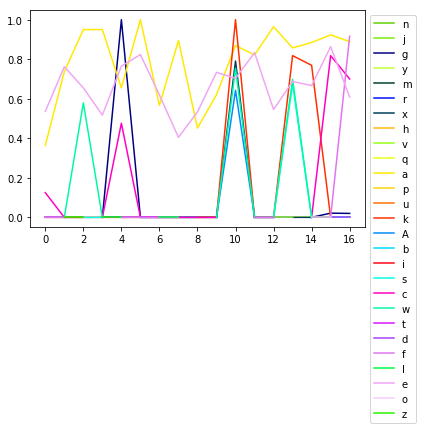

In [264]:
for com in changes:
    plt.plot(changes[com], label=com, color=color_dict[com])
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

/home/dafne/anaconda2/envs/caselaw/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/dafne/anaconda2/envs/caselaw/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


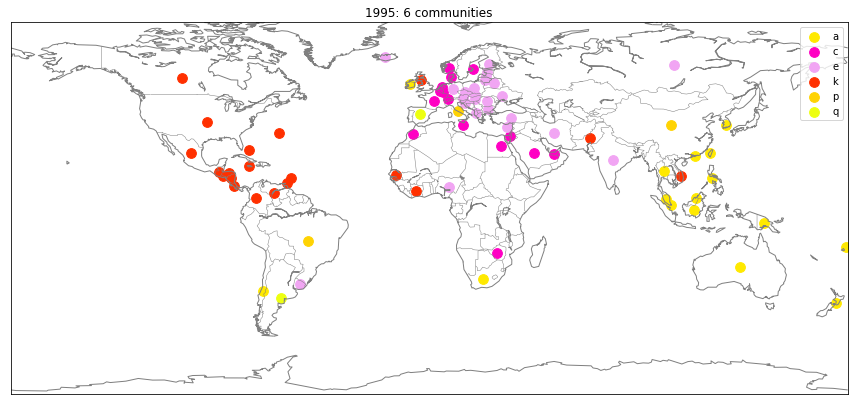

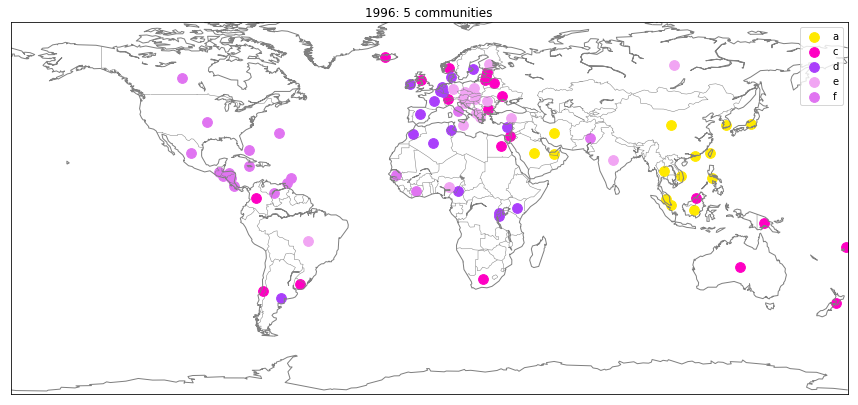

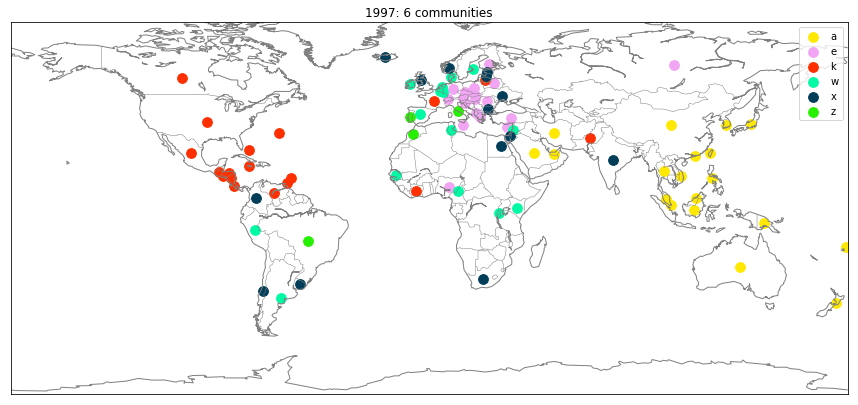

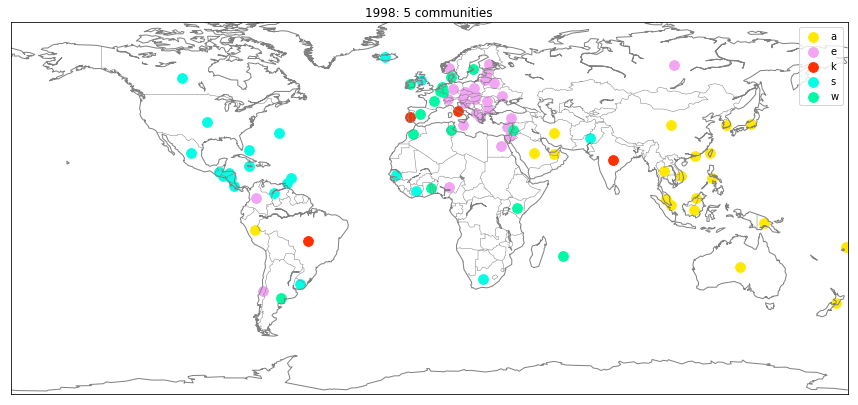

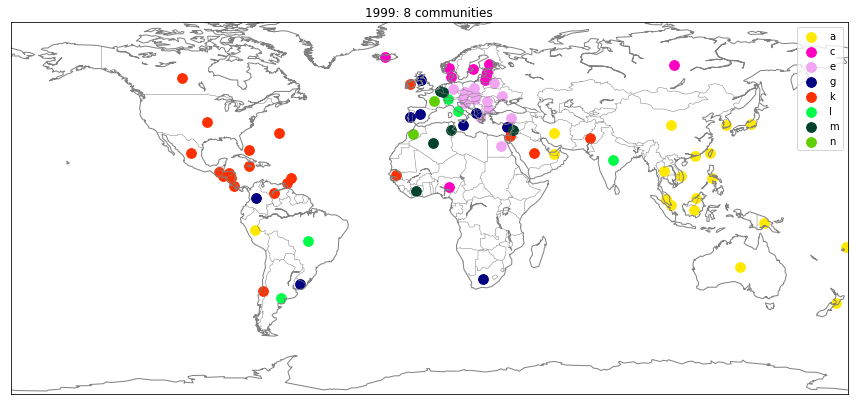

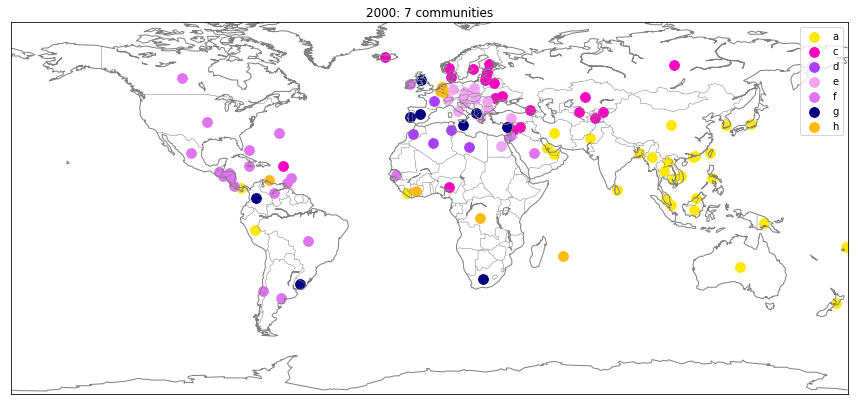

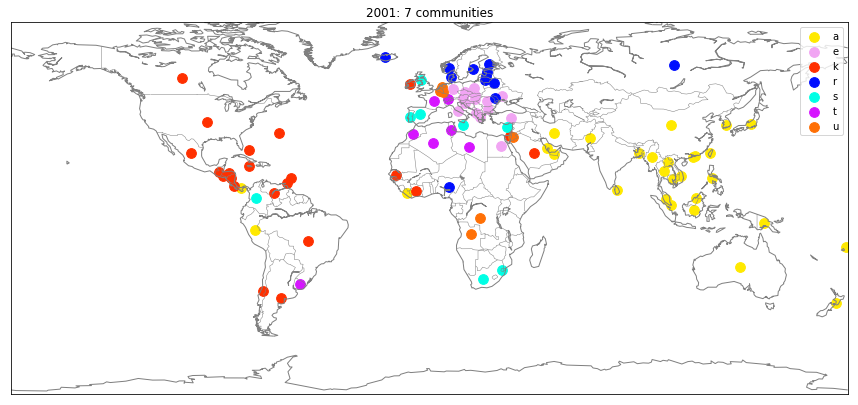

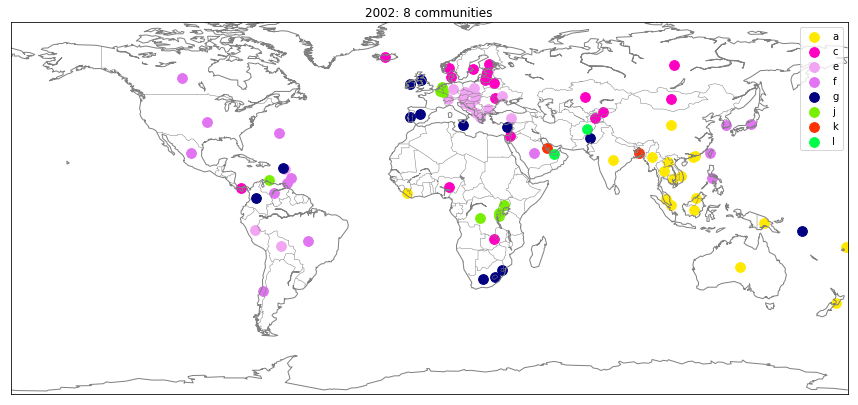

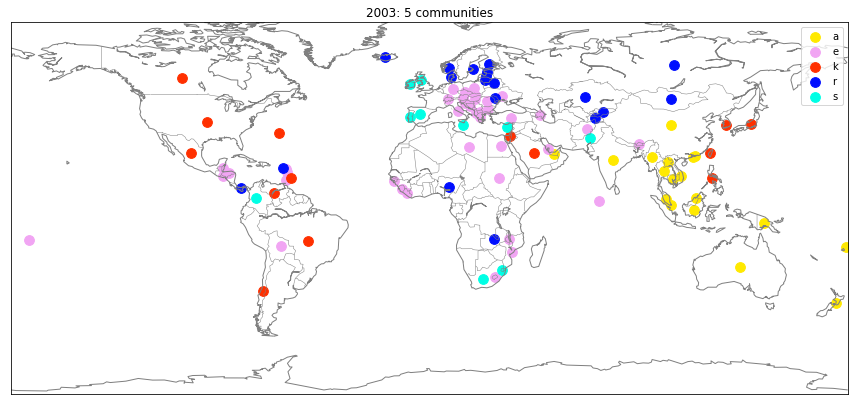

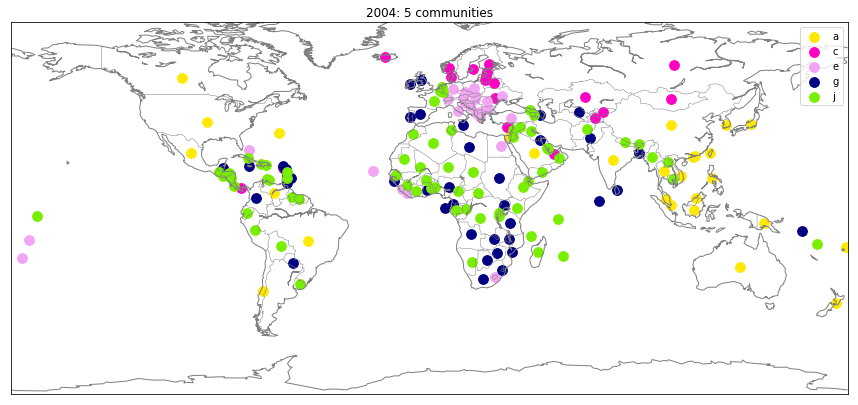

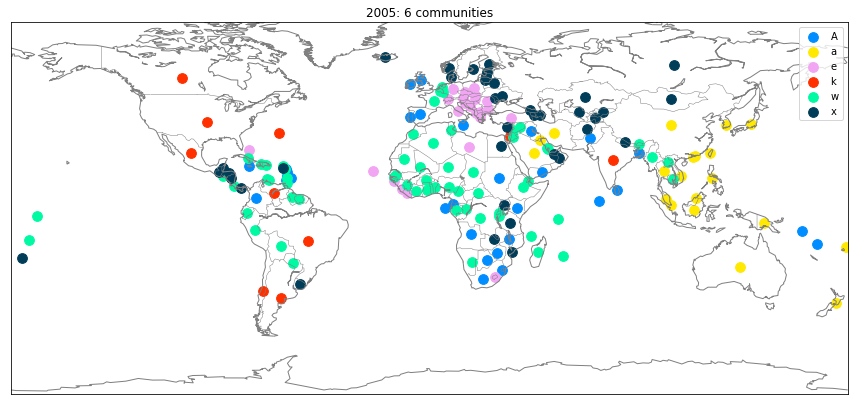

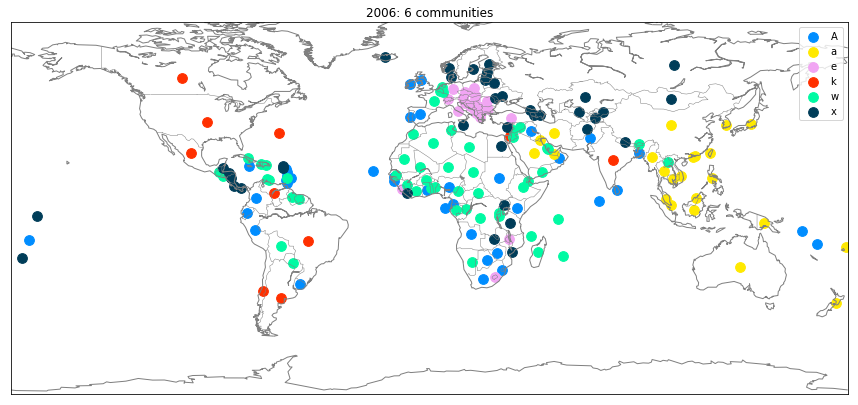

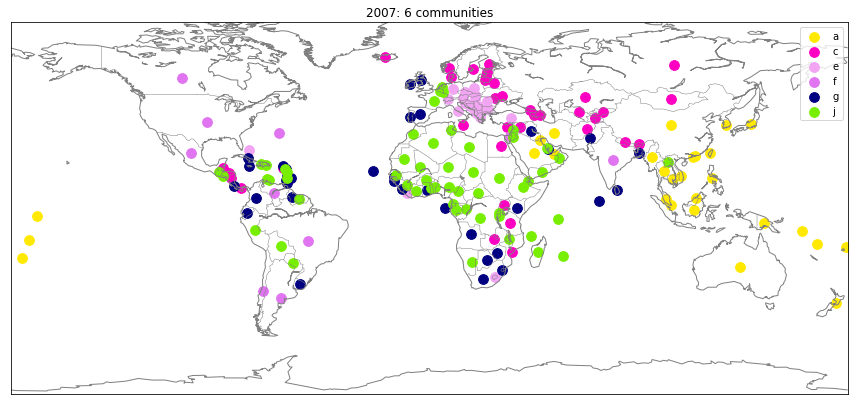

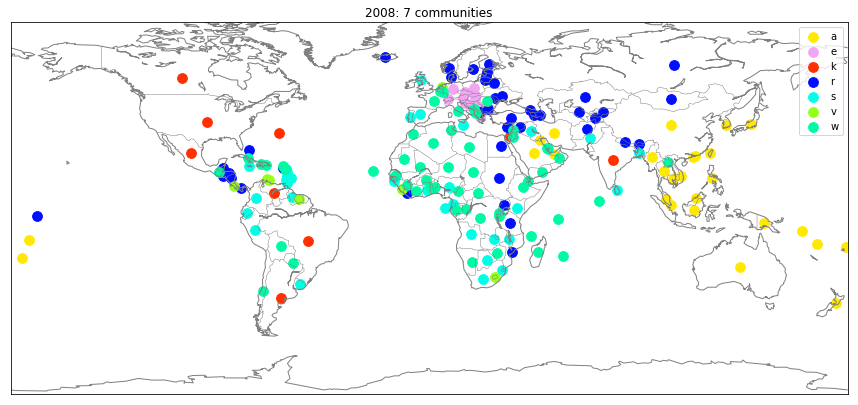

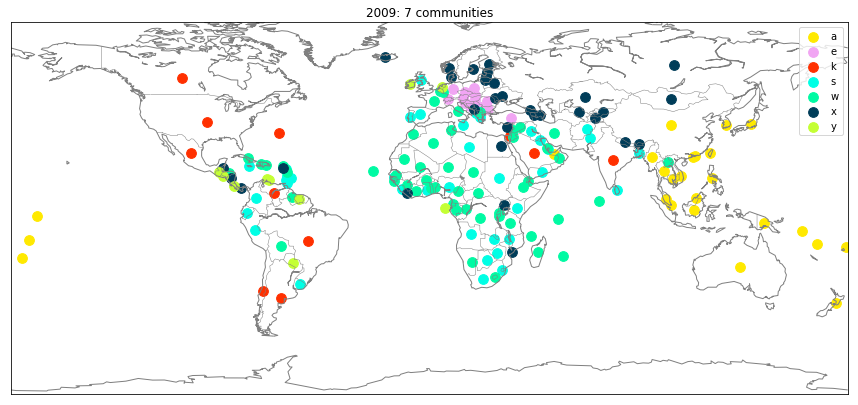

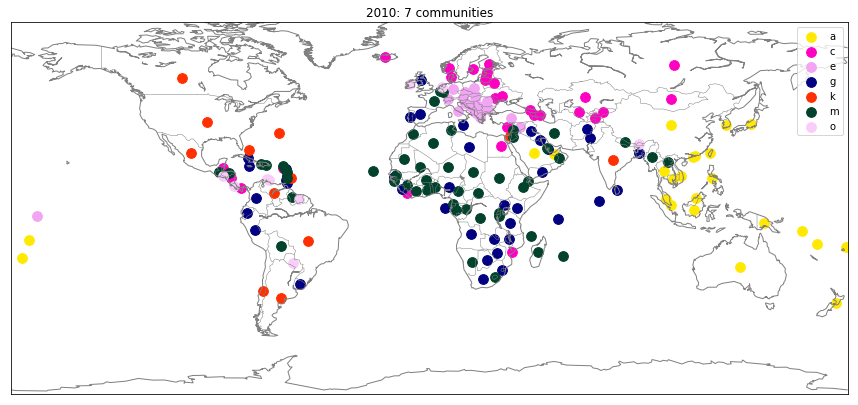

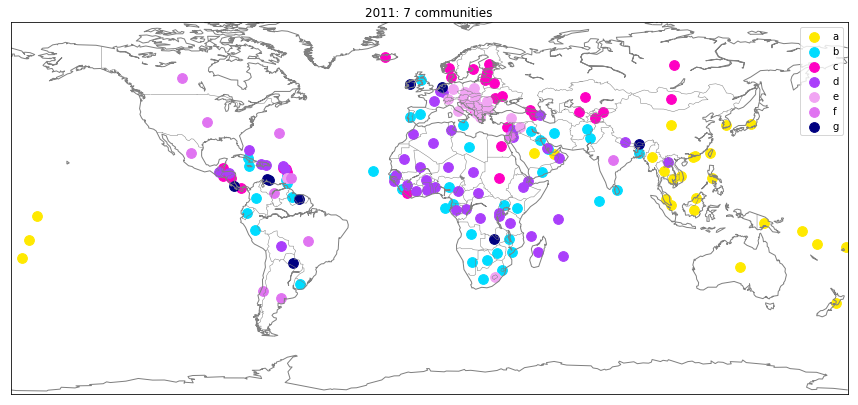

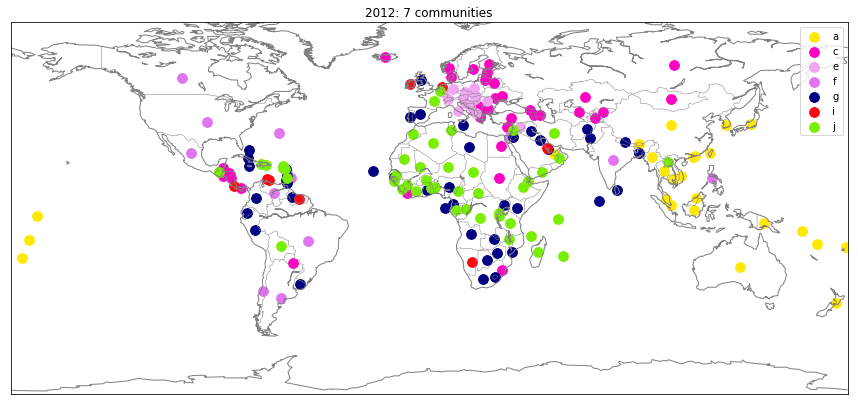

In [265]:
nr_plots = len(graphs)
for i, year in enumerate(sorted(graphs)):
    fig = plt.figure(figsize=(15, 10))
    ax = plt.gca()
    if i<nr_plots:
        att = 'consensus_mapped_{}'.format(year)
        n = nodes_merged[att].nunique()
        m = plot_communities(nodes_merged, att, ax, color_dict=color_dict)
        ax.set_title('{}: {} communities'.format(year, n))
        plt.show()

In [218]:
ax 

,Label,latitude,longitude,name,consensus_2011,consensus_1996,consensus_2000,consensus_2012,consensus_2007,consensus_2002,...,consensus_mapped_2003,consensus_mapped_2004,consensus_mapped_2005,consensus_mapped_2006,consensus_mapped_2007,consensus_mapped_2008,consensus_mapped_2009,consensus_mapped_2010,consensus_mapped_2011,consensus_mapped_2012
Id,,,,,,,,,,,,,,,,,,,,,
BR,Brazil,-14.235004,-51.925280,Brazil,0.0,3.0,4.0,2.0,0.0,79.0,...,e,e,i,i,i,i,i,i,i,i
IT,Italy,41.871940,12.567380,Italy,5.0,2.0,3.0,5.0,2.0,NaN,...,b,b,b,b,b,k,k,b,b,b
MA,Morocco,31.791702,-7.092620,Morocco,6.0,4.0,1.0,6.0,4.0,NaN,...,None,i,j,j,j,k,k,k,k,k
PT,Portugal,39.399872,-8.224454,Portugal,1.0,NaN,5.0,7.0,5.0,90.0,...,h,h,h,h,h,h,h,h,h,h
